In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from nnSampleVerification import sdfs, verifMethods, plotter

In [2]:
import timeit

betaDKW = 0.001
epsilonDKW = 0.001
verifDKW = verifMethods.dkw(epsilonDKW,betaDKW)
betaScenario = 0.001
DeltaScenario = 1-0.999
verifScenario = verifMethods.scenario(DeltaScenario,betaScenario)
print(verifDKW.num_samples)
print(verifScenario.num_samples)

# Define the parameters of the distribution
num_dimensions = 4


# Generate samples from a standard Cauchy distribution
samplesDKW = np.random.standard_cauchy((verifDKW.num_samples, num_dimensions))
samplesScenario = np.random.standard_cauchy((verifScenario.num_samples, num_dimensions))

class ReLUFeedforwardNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ReLUFeedforwardNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        nn.init.normal_(self.fc1.weight, mean=0, std=0.01)
        nn.init.normal_(self.fc1.bias, mean=0, std=0.01)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        nn.init.normal_(self.fc1.weight, mean=0, std=0.01)
        nn.init.normal_(self.fc1.bias, mean=0, std=0.01)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Define the dimensions of the network
input_size = num_dimensions
hidden_size = 10
output_size = 2

# Create an instance of the ReLU feedforward network
network = ReLUFeedforwardNetwork(input_size, hidden_size, output_size)
torch.nn.init.xavier_uniform_(network.fc1.weight)
torch.nn.init.xavier_uniform_(network.fc2.weight)

# Convert samples to a PyTorch tensor
samples_tensor_DKW = torch.tensor(samplesDKW, dtype=torch.float32)
samples_tensor_Scenario = torch.tensor(samplesScenario, dtype=torch.float32)

# Evaluate the network using the samples
output_tensor_DKW = network(samples_tensor_DKW)
output_tensor_Scenario = network(samples_tensor_Scenario)

# Convert the output to a numpy array
samplesDKW = output_tensor_DKW.detach().cpu().numpy()
samplesScenario = output_tensor_Scenario.detach().cpu().numpy()



# Add samples to the verifier
verifDKW.addSamples(samplesDKW)
verifScenario.addSamples(samplesScenario)

# Center of the norm-ball
center = np.array(0.0)
zero_radius_fixed = np.array(10)
normSDF = sdfs.norm(center,zero_radius_fixed,norm=2)

# Add SDF: 
verifDKW.addSpecification(normSDF)
verifScenario.addSpecification(normSDF)

# Run the verification
print(verifDKW.empiricalCDF(0.0))

# Run ZeroOne
verifDKW.findZeroOne(0.1)
print(verifDKW.zeroOne)

levelProb = 0.999
levelSetDKW = verifDKW.findLevelSet(levelProb)
levelSetScenario = verifScenario.findLevelSet()


print("DKW Level-Set: " + str(levelSetDKW))
print("DKW Level-Set Probability: " + str(verifDKW.empiricalCDF(levelSetDKW)))
print("Scenario Level-Set: " + str(levelSetScenario))

3800452
12510
0.8680367493129765


/home/parthasarathy/.local/lib/python3.10/site-packages/scipy/optimize/_root_scalar.py:298: RuntimeWarning: Tolerance of 276996.39903762157 reached.
  r, sol = methodc(f, x0, args=args, fprime=None, fprime2=None,


[-6.65797982e+01  1.03889850e+06]
DKW Level-Set: 1273.2636907360938
DKW Level-Set Probability: 0.9990001189332216
Scenario Level-Set: 23528.1178024162


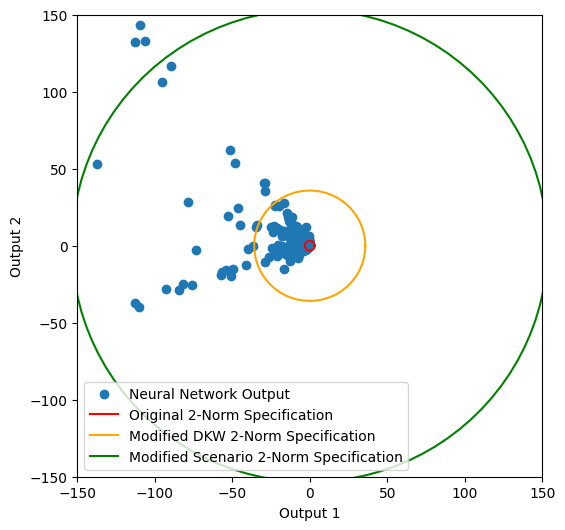

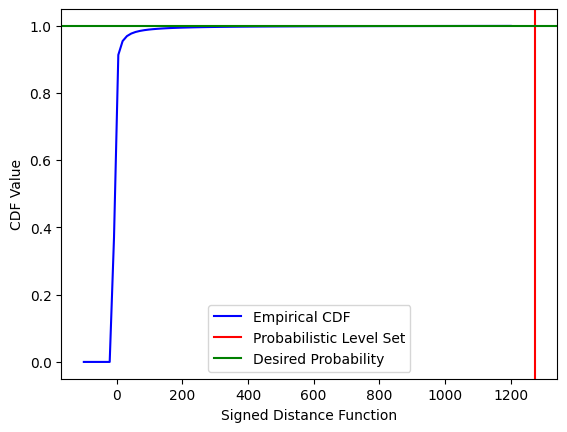

In [3]:
# Create a plot
plt.figure(figsize=(6, 6))

# Plot the samples
plt.plot(samplesDKW[0:1000,0],samplesDKW[0:1000,1], 'o', label='Neural Network Output')

# Plot 2-norm ball of a specific radius
theta = np.linspace(0, 2 * np.pi, 100)
x = np.sqrt(zero_radius_fixed) * np.cos(theta)
y = np.sqrt(zero_radius_fixed) * np.sin(theta)
plt.plot(x, y, 'r',label='Original 2-Norm Specification')

# Plot 2-norm ball of a specific radius
theta = np.linspace(0, 2 * np.pi, 100)
x = np.sqrt(zero_radius_fixed+levelSetDKW) * np.cos(theta)
y = np.sqrt(zero_radius_fixed+levelSetDKW) * np.sin(theta)
plt.plot(x, y, 'orange',label='Modified DKW 2-Norm Specification')

theta = np.linspace(0, 2 * np.pi, 100)
x = np.sqrt(zero_radius_fixed+levelSetScenario) * np.cos(theta)
y = np.sqrt(zero_radius_fixed+levelSetScenario) * np.sin(theta)
plt.plot(x, y, 'green',label='Modified Scenario 2-Norm Specification')


# Add labels and title
plt.xlabel('Output 1')
plt.ylabel('Output 2')

plt.legend(loc='best')
# Set axis limits
plt.xlim(-150, 150)
plt.ylim(-150, 150)

# Show the plot
plt.show()

evalPts = np.linspace(-100,1200,100)
plotter.histogramPlot(verifDKW.empiricalCDF,evalPts,levelSetDKW,levelProb)